# ![scikit-learn](https://img.shields.io/badge/scikit--learn-%23F7931E.svg?style=for-the-badge&logo=scikit-learn&logoColor=white) **CHAPTER 2 - END-TO-END MACHINE LEARNING PROJECT**

---

## **SETUP:**

In [94]:
# This notebook requires Python 3.7 or above and Scikit-Learn 1.0.1 or above.
import sys
from packaging import version
import sklearn

assert sys.version_info >= (3, 7)
assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

In [95]:
# Common libraries.
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

# Default settings for matplotlib.
plt.rc("font", size=14)
plt.rc("axes", labelsize=14, titlesize=14)
plt.rc("legend", fontsize=14)
plt.rc("xtick", labelsize=12)
plt.rc("ytick", labelsize=12)

In [96]:
# Create a directory for matplotlib images.
from pathlib import Path

IMAGES_PATH = Path("images")
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300, facecolor="w"):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution, facecolor=facecolor)

---

## **DOWNLOAD THE DATA:**

In [97]:
from pathlib import Path
import tarfile
import urllib.request

def load_housing_data():
    tarball_path = Path("data/housing.tgz")
    if not tarball_path.is_file():
        Path("data").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url, tarball_path)
        with tarfile.open(tarball_path) as housing_tarball:
            housing_tarball.extractall(path="data")
    return pd.read_csv(Path("data/housing.csv"))

housing = load_housing_data()

---

## **QUICK LOOK AT THE DATA STRUCTURE**

In [98]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [99]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [100]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [101]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


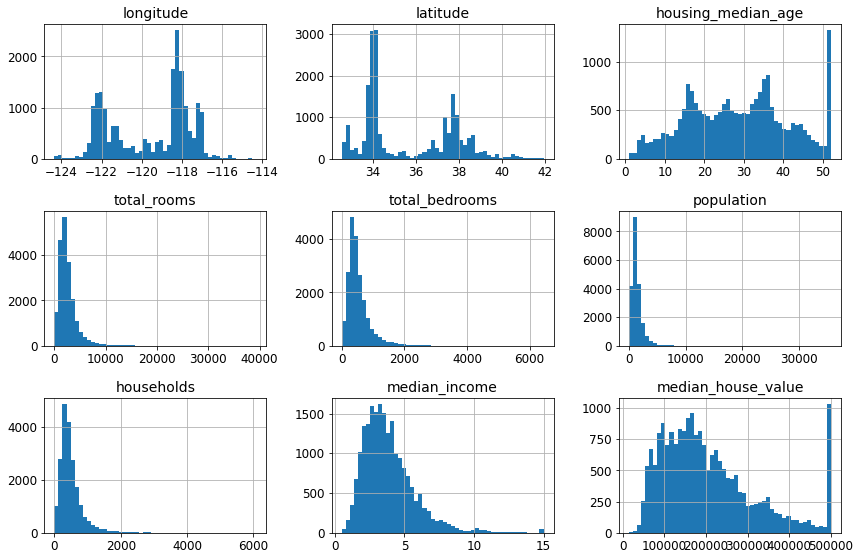

In [102]:
housing.hist(bins=50, figsize=(12, 8))
save_fig("attribute_histogram")
plt.show()

---

## **CREATE A TEST SET**

### **1. BY HAND**

In [103]:
# The most ordinary split method.

def shuffle_and_split(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    train_indices = shuffled_indices[test_set_size:]
    test_indices = shuffled_indices[:test_set_size]
    return data.iloc[train_indices], data.iloc[test_indices]

np.random.seed(42)  # This ensures repeatable datasets.
train_set, test_set = shuffle_and_split(housing, 0.2)
len(train_set), len(test_set)

(16512, 4128)

### **2. BY USING HASH**

In [104]:
# Note: there we have to set PYTHONHASHSEED environment variable to 0
# in order to provide repeatable datasets.

from zlib import crc32

def is_id_in_test_set(identifier, test_ratio):
    return crc32(np.int64(identifier)) < test_ratio * 2 ** 32  # type: ignore

def split_data_with_id_hash(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: is_id_in_test_set(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

housing_with_id = housing.reset_index()
train_set, test_set = split_data_with_id_hash(housing_with_id, 0.2, "index")
len(train_set), len(test_set)
 

(16512, 4128)

### **3. WITH SCIKIT-LEARN**

In [105]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)
len(train_set), len(test_set)

(16512, 4128)

---

## **STRATIFIED SHUFFLE SPLIT**

When we suspect that the dataset should be split according to different groups. We can use the strafified sampling. Suppose we have a 1000 people, where 52% of them are women and 48% are men. If we want to provide representative groups, both the train set and test test should contain 52% of women and 48% of men. 

For example, to find the probability that a random sample of 1,000 people contains less than 48.5% female or more than 53.5% female when the population's female ratio is 51.1%, we use the [binomial distribution](https://en.wikipedia.org/wiki/Binomial_distribution). The `cdf()` method of the binomial distribution gives us the probability that the number of females will be equal or less than the given value.

In [106]:
from scipy.stats import binom

sample_size = 1000
ratio_female = 0.511
proba_too_small = binom(sample_size, ratio_female).cdf(485 - 1)
proba_too_large = 1 - binom(sample_size, ratio_female).cdf(535)
proba_too_small + proba_too_large  # Around 10% that we get a bad sample.

0.10736798530929909

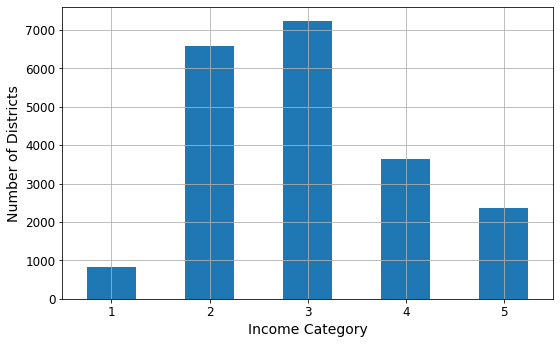

In [107]:
# Let's create a median category depending on the median income.

housing["income_cat"] = pd.cut(housing["median_income"], 
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])
housing["income_cat"].value_counts().sort_index().plot.bar(rot=0, grid=True, figsize=(8, 5))
plt.xlabel("Income Category")
plt.ylabel("Number of Districts")
save_fig("housing_income_cat")
plt.show()

In [108]:
# Stratified shuffle split by the given attribute.

from sklearn.model_selection import StratifiedShuffleSplit

splitter = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
strat_splits = []
for train_id, test_id in splitter.split(housing, housing["income_cat"]):
    strat_train_set_n = housing.iloc[train_id]
    strat_test_set_n = housing.iloc[test_id]
    strat_splits.append([strat_train_set_n, strat_test_set_n])
    
strat_train_set, strat_test_set = strat_splits[0]
len(strat_train_set), len(strat_test_set)

(16512, 4128)

In [109]:
# Single stratified split.
strat_train_set, strat_test_set = train_test_split(
    housing, test_size=0.2, stratify=housing["income_cat"], random_state=42
)
len(strat_train_set), len(strat_test_set)

(16512, 4128)

In [110]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)  # type: ignore

3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: income_cat, dtype: float64

In [111]:
# Error with ordinary shuffle and stratified shuffle.

def income_cat_proportions(data):
    return data["income_cat"].value_counts() / len(data)

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({
    "Overall %": income_cat_proportions(housing),
    "Stratified %": income_cat_proportions(strat_test_set),
    "Random %": income_cat_proportions(test_set),
}).sort_index()

compare_props.index.name = "Income Category"
compare_props["Strat. Error %"] = (compare_props["Stratified %"] /
                                   compare_props["Overall %"] - 1)
compare_props["Rand. Error %"] = (compare_props["Random %"] /
                                   compare_props["Overall %"] - 1)
(compare_props * 100).round(2)

,Overall %,Stratified %,Random %,Strat. Error %,Rand. Error %
Income Category,,,,,
1,3.98,4.00,4.02,0.36,0.97
2,31.88,31.88,32.44,-0.02,1.73
3,35.06,35.05,35.85,-0.01,2.27
4,17.63,17.64,16.74,0.03,-5.06
5,11.44,11.43,10.95,-0.08,-4.32


In [112]:
# We can drop income category now.

for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)  # type: ignore

---

## **DISCOVER AND VISUALIZE THE DATA**

### **1. VISUALIZING GEOGRAPHICAL DATA**

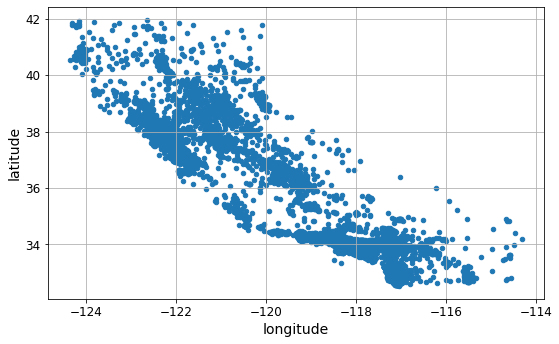

In [113]:
housing: pd.DataFrame = strat_train_set.copy()  # type: ignore
housing.plot(kind="scatter", x="longitude", y="latitude", grid=True, figsize=(8, 5))  # type: ignore
save_fig("bad_visualization")
plt.show()

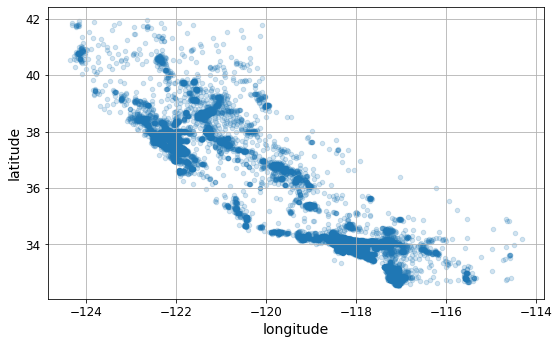

In [114]:
housing.plot(kind="scatter", x="longitude", y="latitude", grid=True, alpha=0.2, figsize=(8, 5))  # type: ignore
save_fig("better_visualization")
plt.show()

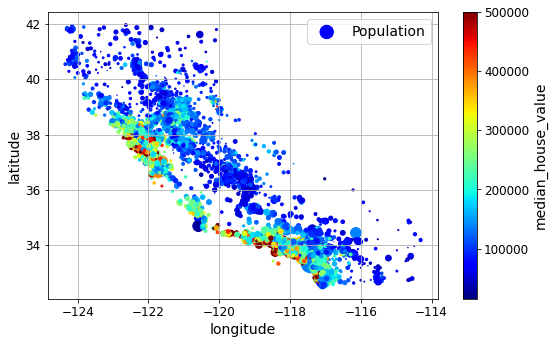

In [115]:
housing.plot(kind="scatter", x="longitude", y="latitude", grid=True, label="Population",
             s=housing["population"] / 100, c = "median_house_value", cmap="jet",
             colorbar=True, legend=True, sharex=False, figsize=(8, 5))
save_fig("housing_prices_scatterplot")
plt.show()

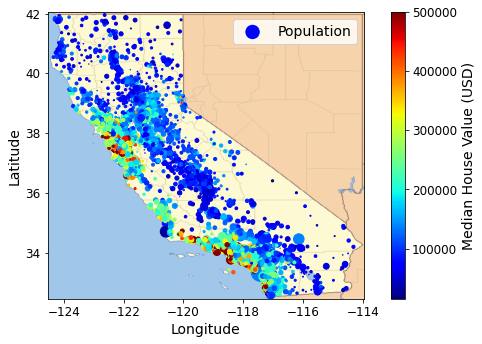

In [116]:
filename = "california.png"
if not (IMAGES_PATH / filename).is_file():
    homl3_root = "https://github.com/ageron/handson-ml3/raw/main/"
    url = homl3_root + "images/end_to_end_project/" + filename
    print("Downloading", filename)
    urllib.request.urlretrieve(url, IMAGES_PATH / filename)
    
housing_renamed = housing.rename(columns={
    "latitude": "Latitude",
    "longitude": "Longitude",
    "population": "Population",
    "median_house_value": "Median House Value (USD)"
})

housing_renamed.plot(
    kind="scatter",
    x="Longitude",
    y="Latitude",
    s=housing_renamed["Population"] / 100,
    label="Population",
    c="Median House Value (USD)",
    cmap="jet",
    colorbar=True,
    legend=True,
    sharex=False,
    figsize=(8, 5)
)

california_img = plt.imread(IMAGES_PATH / filename)  # type: ignore
axis = -124.55, -113.95, 32.45, 42.05
plt.axis(axis)
plt.imshow(california_img, extent=axis)
save_fig("california_housing_prices")
plt.show()

### **2. LOOKING FOR CORRELATIONS**

In [117]:
corr_matrix = housing.corr() 
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687151
total_rooms           0.135140
housing_median_age    0.114146
households            0.064590
total_bedrooms        0.047781
population           -0.026882
longitude            -0.047466
latitude             -0.142673
Name: median_house_value, dtype: float64

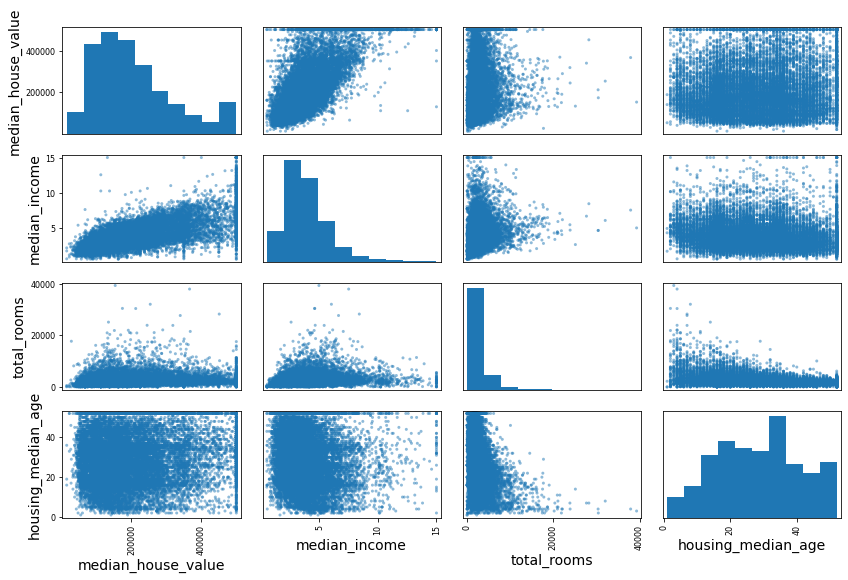

In [118]:
from pandas.plotting import scatter_matrix

scatter_matrix(housing[["median_house_value", "median_income", "total_rooms",
                        "housing_median_age"]], figsize=(12, 8))
save_fig("scatter_matrix")
plt.show()

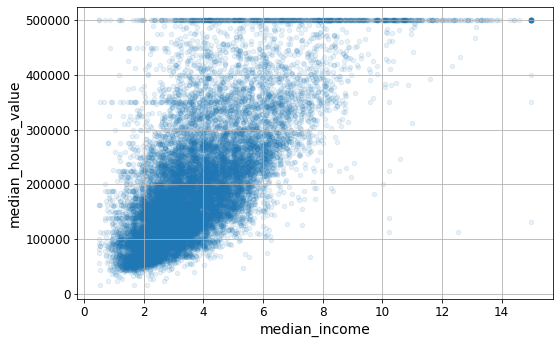

In [119]:
housing.plot(kind="scatter", x="median_income", y="median_house_value",
             grid=True, alpha=0.1, figsize=(8, 5))
save_fig("income_vs_house_value")
plt.show()

### **3. EXPERIMENTING WITH ATTRIBUTE COMBINATIONS**

In [120]:
housing["rooms_per_house"] = housing["total_rooms"] / housing["households"]
housing["bedrooms_ratio"] = housing["total_bedrooms"] / housing["total_rooms"]
housing["people_per_house"] = housing["population"] / housing["households"]
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687151
rooms_per_house       0.146255
total_rooms           0.135140
housing_median_age    0.114146
households            0.064590
total_bedrooms        0.047781
people_per_house     -0.021991
population           -0.026882
longitude            -0.047466
latitude             -0.142673
bedrooms_ratio       -0.259952
Name: median_house_value, dtype: float64

---

## **PREPARE THE DATA FOR MACHINE LEARNING**

In [121]:
# We want to predict median house value.
housing = strat_train_set.drop("median_house_value", axis=1)  # type: ignore
housing_labels = strat_train_set["median_house_value"].copy()  # type: ignore

### **1. HANDLE THE NAN VALUES**

In [122]:
# Check if there are any nulls.
null_rows_idx = housing.isnull().any(axis=1)
housing.loc[null_rows_idx].head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
1606,-122.08,37.88,26.0,2947.0,NaN,825.0,626.0,2.9330,NEAR BAY
10915,-117.87,33.73,45.0,2264.0,NaN,1970.0,499.0,3.4193,<1H OCEAN
19150,-122.70,38.35,14.0,2313.0,NaN,954.0,397.0,3.7813,<1H OCEAN
4186,-118.23,34.13,48.0,1308.0,NaN,835.0,294.0,4.2891,<1H OCEAN
16885,-122.40,37.58,26.0,3281.0,NaN,1145.0,480.0,6.3580,NEAR OCEAN


In [123]:
# Method 1 - we drop rows, where there are nan values.
housing_option1 = housing.copy()
housing_option1.dropna(subset=["total_bedrooms"], inplace=True)
housing_option1.loc[null_rows_idx].head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity


In [124]:
# Method 2 - we drop the whole attribute.
housing_option2 = housing.copy()
housing_option2.drop("total_bedrooms", axis=1, inplace=True)
housing_option2.loc[null_rows_idx].head()

,longitude,latitude,housing_median_age,total_rooms,population,households,median_income,ocean_proximity
1606,-122.08,37.88,26.0,2947.0,825.0,626.0,2.9330,NEAR BAY
10915,-117.87,33.73,45.0,2264.0,1970.0,499.0,3.4193,<1H OCEAN
19150,-122.70,38.35,14.0,2313.0,954.0,397.0,3.7813,<1H OCEAN
4186,-118.23,34.13,48.0,1308.0,835.0,294.0,4.2891,<1H OCEAN
16885,-122.40,37.58,26.0,3281.0,1145.0,480.0,6.3580,NEAR OCEAN


In [125]:
# Method 3 - we fill nan values with a median.
housing_option3 = housing.copy()
median = housing["total_bedrooms"].median()
housing_option3["total_bedrooms"].fillna(median, inplace=True)
housing_option3.loc[null_rows_idx].head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
1606,-122.08,37.88,26.0,2947.0,433.0,825.0,626.0,2.9330,NEAR BAY
10915,-117.87,33.73,45.0,2264.0,433.0,1970.0,499.0,3.4193,<1H OCEAN
19150,-122.70,38.35,14.0,2313.0,433.0,954.0,397.0,3.7813,<1H OCEAN
4186,-118.23,34.13,48.0,1308.0,433.0,835.0,294.0,4.2891,<1H OCEAN
16885,-122.40,37.58,26.0,3281.0,433.0,1145.0,480.0,6.3580,NEAR OCEAN


In [126]:
# Filling nan values with scikit-learn.

from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")
# Imputer with median strategy works only for the numeric attributes.
housing_num = housing.select_dtypes(include=[np.number])
imputer.fit(housing_num)
imputer.statistics_

array([-118.51   ,   34.26   ,   29.     , 2119.     ,  433.     ,
       1164.     ,  408.     ,    3.54155])

In [127]:
housing_num.median().values  # Should be the same.

array([-118.51   ,   34.26   ,   29.     , 2119.     ,  433.     ,
       1164.     ,  408.     ,    3.54155])

In [128]:
# Transform the training set (using the calculated median)
X = imputer.transform(housing_num)
X[:2]  # Numpy array.

array([[-1.2146e+02,  3.8520e+01,  2.9000e+01,  3.8730e+03,  7.9700e+02,
         2.2370e+03,  7.0600e+02,  2.1736e+00],
       [-1.1723e+02,  3.3090e+01,  7.0000e+00,  5.3200e+03,  8.5500e+02,
         2.0150e+03,  7.6800e+02,  6.3373e+00]])

In [129]:
imputer.feature_names_in_

array(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income'],
      dtype=object)

In [130]:
# Recover the pandas dataframe with transformed attributes.
housing_tr = pd.DataFrame(X, columns=housing_num.columns, index=housing_num.index)
housing_tr.loc[null_rows_idx].head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
1606,-122.08,37.88,26.0,2947.0,433.0,825.0,626.0,2.9330
10915,-117.87,33.73,45.0,2264.0,433.0,1970.0,499.0,3.4193
19150,-122.70,38.35,14.0,2313.0,433.0,954.0,397.0,3.7813
4186,-118.23,34.13,48.0,1308.0,433.0,835.0,294.0,4.2891
16885,-122.40,37.58,26.0,3281.0,433.0,1145.0,480.0,6.3580


### **2. HANDLE THE OUTLIERS**

In [131]:
# Detect outliers with the IsolationForest.

from sklearn.ensemble import IsolationForest

isolation_forest = IsolationForest(random_state=42)
outlier_pred = isolation_forest.fit_predict(X)
outlier_pred

array([ 1, -1,  1, ...,  1,  1,  1])

In [132]:
# Drop outliers.
# housing = housing.iloc[outlier_pred == 1]
# housing_labels = housing_labels.loc[outlier_pred == 1]

### **3. HANDLE THE TEXT AND CATEGORICAL ATTRIBUTES**

In [133]:
housing_cat = housing[["ocean_proximity"]]  # [[]] makes data frame, meanwhile [] makes a series.
housing_cat.head()

,ocean_proximity
12655,INLAND
15502,NEAR OCEAN
2908,INLAND
14053,NEAR OCEAN
20496,<1H OCEAN


In [134]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:5]

array([[1.],
       [4.],
       [1.],
       [4.],
       [0.]])

In [135]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [136]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot  # Sparse matrix.

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [137]:
housing_cat_1hot.toarray()  # Dense matrix.

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [138]:
# Alternatively, set sparse=False
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder(sparse=False)
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot  # Dense matrix.

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [139]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [140]:
# Example dataframe to show the one hot encoder works.
df_test = pd.DataFrame({"ocean_proximity": ["INLAND", "NEAR BAY"]})
pd.get_dummies(df_test)

,ocean_proximity_INLAND,ocean_proximity_NEAR BAY
0,1,0
1,0,1


In [141]:
cat_encoder.transform(df_test)

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [142]:
# How to handle the unknown category
df_test_unknown = pd.DataFrame({"ocean_proximity": ["<2H OCEAN", "NEAR BAY"]})
pd.get_dummies(df_test_unknown)

,ocean_proximity_<2H OCEAN,ocean_proximity_NEAR BAY
0,1,0
1,0,1


In [143]:
cat_encoder.handle_unknown = "ignore"  # Just ignore the unknown categories.
cat_encoder.transform(df_test_unknown)

array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [144]:
cat_encoder.feature_names_in_

array(['ocean_proximity'], dtype=object)

In [145]:
cat_encoder.get_feature_names_out()

array(['ocean_proximity_<1H OCEAN', 'ocean_proximity_INLAND',
       'ocean_proximity_ISLAND', 'ocean_proximity_NEAR BAY',
       'ocean_proximity_NEAR OCEAN'], dtype=object)

In [146]:
df_output = pd.DataFrame(cat_encoder.transform(df_test_unknown),  # type: ignore
                         columns=cat_encoder.get_feature_names_out(),
                         index=df_test_unknown.index)
df_output

,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,1.0,0.0


### **4. FEATURE SCALING**

In [147]:
# Method 1.
from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler(feature_range=(-1, 1))
housing_num_min_max_scaled = min_max_scaler.fit_transform(housing_num)
housing_num_min_max_scaled[:2]

array([[-0.42430279,  0.27098831,  0.09803922, -0.80327619, -0.74387887,
        -0.87477228, -0.73711725, -0.76914801],
       [ 0.41832669, -0.88310308, -0.76470588, -0.72966373, -0.7251933 ,
        -0.88721657, -0.71396565, -0.19485248]])

In [148]:
# Method 2.
from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler()
housing_num_std_scaled = std_scaler.fit_transform(housing_num)
housing_num_std_scaled[:2]

array([[-0.94135046,  1.34743822,  0.02756357,  0.58477745,  0.63512283,
         0.73260236,  0.55628602, -0.8936472 ],
       [ 1.17178212, -1.19243966, -1.72201763,  1.26146668,  0.77567675,
         0.53361152,  0.72131799,  1.292168  ]])

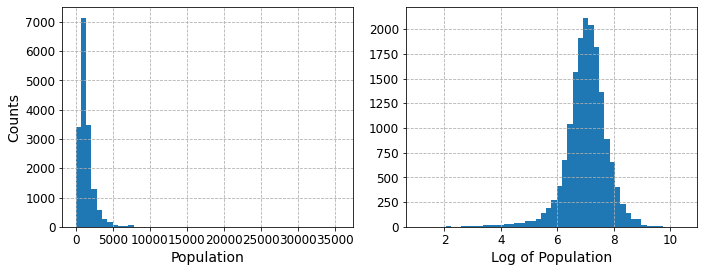

In [149]:
# Longtail distributions - if we have such distributions, it is better to swap these with their log.

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.hist(housing["population"], bins=50)
plt.xlabel("Population")
plt.ylabel("Counts")
plt.grid(linestyle="dashed")
plt.subplot(1, 2, 2)
plt.hist(housing["population"].apply(np.log), bins=50)
plt.xlabel("Log of Population")
plt.grid(linestyle="dashed")
save_fig("long_tail")
plt.show()

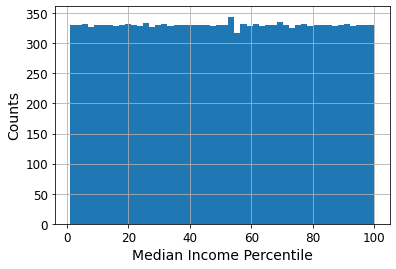

In [150]:
# Test - replace each value with its percentile.
# We get a uniform distribution.
percentiles = [np.percentile(housing["median_income"], p) for p in range(1, 100)]
flattened_median_income = pd.cut(  # We connect each value with one percentile.
    housing["median_income"],
    bins=[-np.inf] + percentiles + [np.inf],
    labels=range(1, 100 + 1)
)
flattened_median_income.hist(bins=50)
plt.xlabel("Median Income Percentile")
plt.ylabel("Counts")
plt.show()

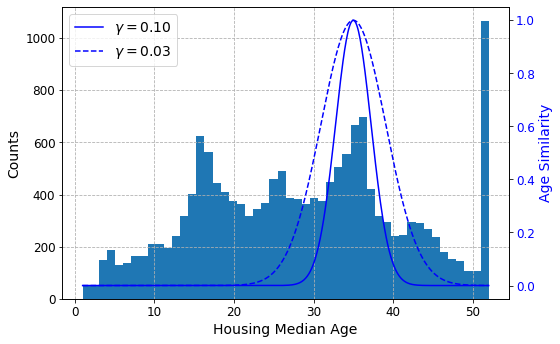

In [151]:
from sklearn.metrics.pairwise import rbf_kernel

ages = np.linspace(housing["housing_median_age"].min(),
                   housing["housing_median_age"].max(),
                   500).reshape(-1, 1)
gamma1 = 0.10
gamma2 = 0.03
rbf1 = rbf_kernel(ages, [[35]], gamma=gamma1)
rbf2 = rbf_kernel(ages, [[35]], gamma=gamma2)

fig, ax1 = plt.subplots(figsize=(8, 5))

ax1.hist(housing["housing_median_age"], bins=50)
ax1.set_xlabel("Housing Median Age")
ax1.set_ylabel("Counts")
ax1.grid(linestyle="dashed")

ax2 = ax1.twinx()  # Twin axis that shares the same x-axis.
ax2.plot(ages, rbf1, color="blue", label=r"$\gamma = 0.10$")
ax2.plot(ages, rbf2, color="blue", label=r"$\gamma = 0.03$", linestyle="--")
ax2.tick_params(axis="y", labelcolor="blue")
ax2.set_ylabel("Age Similarity", color="blue")

plt.legend(loc="upper left")
save_fig("age_similarity")
plt.show()


---

## **CUSTOM TRANSFORMERS**

In [152]:
# Simple transformer.
from sklearn.preprocessing import FunctionTransformer

log_transformer = FunctionTransformer(np.log, np.exp)
log_population = log_transformer.transform(housing[["population"]])
log_population[:5]

,population
12655,7.712891
15502,7.608374
2908,6.502790
14053,6.800170
20496,7.515889


In [153]:
population = log_transformer.inverse_transform(log_population)
population[:5]

,population
12655,2237.0
15502,2015.0
2908,667.0
14053,898.0
20496,1837.0


In [154]:
rbf_transformer = FunctionTransformer(rbf_kernel, kw_args=dict(Y=[[35]], gamma=0.1))
age_simil_35 = rbf_transformer.transform(housing[["housing_median_age"]])
age_simil_35[:5]

array([[2.73237224e-02],
       [8.93948745e-35],
       [3.03539138e-04],
       [5.55951324e-06],
       [1.66155727e-03]])

In [155]:
ratio_transformer = FunctionTransformer(lambda X: X[:, [0]] / X[:, [1]])
ratio_transformer.transform(np.array([[1, 2], [3, 4]]))

array([[0.5 ],
       [0.75]])

In [156]:
# Own class transformer.

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_array, check_is_fitted

class StandardScalerClone(BaseEstimator, TransformerMixin):
    def __init__(self, with_mean=True):  # NO *args, **kwargs.
        self.with_mean = with_mean
    
    def fit(self, X, y=None):  # y is required even though we don't use it.
        X = check_array(X)  # Check if the X is an array with finite float values.
        self.mean_ = X.mean(axis=0)
        self.scale_ = X.std(axis=0)
        self.n_features_in_ = X.shape[1]  # Every estimator stores this in fit()
        return self  # Always return self.
    
    def transform(self, X):
        check_is_fitted(self)  # Looks for learned attributes (with trailing _)
        X = check_array(X)
        assert self.n_features_in_ == X.shape[1]
        if self.with_mean:
            X = X - self.mean_
        return X / self.scale_

In [157]:
from sklearn.cluster import KMeans

class ClusterSimilarity(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters=10, gamma=1.0, random_state=None):
        self.n_clusters = n_clusters
        self.gamma = gamma
        self.random_state = random_state
    
    def fit(self, X, y=None, sample_weight=None):
        self.kmeans_ = KMeans(self.n_clusters, random_state=self.random_state)
        self.kmeans_.fit(X, sample_weight=sample_weight)
        return self
    
    def transform(self, X):
        return rbf_kernel(X, self.kmeans_.cluster_centers_, gamma=self.gamma)
    
    def get_feature_names_out(self, names=None):
        return [f"Cluster {i} similarity" for i in range(self.n_clusters)]

In [158]:
cluster_simil = ClusterSimilarity(n_clusters=10, gamma=1.0, random_state=42)
similarities = cluster_simil.fit_transform(housing[["latitude", "longitude"]],
                                           sample_weight=housing_labels)
similarities[:2].round(2)

array([[0.  , 0.49, 0.31, 0.  , 0.  , 0.  , 0.  , 0.85, 0.  , 0.16],
       [0.4 , 0.  , 0.  , 0.  , 0.  , 0.95, 0.11, 0.  , 0.  , 0.  ]])

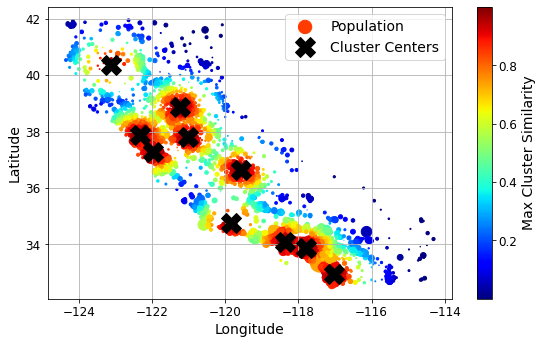

In [159]:
housing_renamed = housing.rename(columns={
    "latitude": "Latitude",
    "longitude": "Longitude",
    "population": "Population",
    "median_house_value": "Median House Value (USD)",
})
housing_renamed["Max Cluster Similarity"] = similarities.max(axis=1)

housing_renamed.plot(
    kind="scatter",
    x="Longitude",
    y="Latitude",
    s=housing_renamed["Population"] / 100,
    label="Population",
    c="Max Cluster Similarity",
    cmap="jet",
    grid=True,
    colorbar=True,
    legend=True,
    sharex=False,
    figsize=(8, 5)
)

plt.plot(
    cluster_simil.kmeans_.cluster_centers_[:, 1],
    cluster_simil.kmeans_.cluster_centers_[:, 0],
    linestyle="",
    color="black",
    marker="X",
    markersize=20,
    label="Cluster Centers"
)
plt.legend(loc="upper right")
save_fig("district_cluster_plot")
plt.show()

---

## **TRANSFORMATION PIPELINES**

In [160]:
# Pipeline to preprocess numerical attributes.
from sklearn.pipeline import Pipeline

num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])
num_pipeline

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler())])

In [161]:
# Second method
from sklearn.pipeline import make_pipeline

num_pipeline = make_pipeline(SimpleImputer(strategy="median"), StandardScaler())
num_pipeline

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler())])

In [162]:
housing_num_prepared = num_pipeline.fit_transform(housing_num)
housing_num_prepared[:2].round(2)

array([[-0.94,  1.35,  0.03,  0.58,  0.64,  0.73,  0.56, -0.89],
       [ 1.17, -1.19, -1.72,  1.26,  0.78,  0.53,  0.72,  1.29]])

In [163]:
# Recover data to the dataframe structure.
df_housing_num_prepared = pd.DataFrame(
    housing_num_prepared, columns=num_pipeline.get_feature_names_out(),
    index=housing_num.index
)
df_housing_num_prepared.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
12655,-0.941350,1.347438,0.027564,0.584777,0.640371,0.732602,0.556286,-0.893647
15502,1.171782,-1.192440,-1.722018,1.261467,0.781561,0.533612,0.721318,1.292168
2908,0.267581,-0.125972,1.220460,-0.469773,-0.545138,-0.674675,-0.524407,-0.525434
14053,1.221738,-1.351474,-0.370069,-0.348652,-0.036367,-0.467617,-0.037297,-0.865929
20496,0.437431,-0.635818,-0.131489,0.427179,0.272790,0.374060,0.220898,0.325752


In [164]:
# Transformer for the whole dataset.

from sklearn.compose import ColumnTransformer

num_attribs = housing.select_dtypes(include=[np.number]).columns
cat_attribs = housing.select_dtypes(include=[object]).columns

cat_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore"),
)

preprocessing = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", cat_pipeline, cat_attribs)
])

housing_prepared = preprocessing.fit_transform(housing)
housing_prepared[:2].round(2)

array([[-0.94,  1.35,  0.03,  0.58,  0.64,  0.73,  0.56, -0.89,  0.  ,
         1.  ,  0.  ,  0.  ,  0.  ],
       [ 1.17, -1.19, -1.72,  1.26,  0.78,  0.53,  0.72,  1.29,  0.  ,
         0.  ,  0.  ,  0.  ,  1.  ]])

In [165]:
# Transformer for the whole dataset - second method.

from sklearn.compose import make_column_selector, make_column_transformer

preprocessing = make_column_transformer(
    (num_pipeline, make_column_selector(dtype_include=np.number)),
    (cat_pipeline, make_column_selector(dtype_include=object)),
)

housing_prepared = preprocessing.fit_transform(housing)
housing_prepared[:2].round(2)

array([[-0.94,  1.35,  0.03,  0.58,  0.64,  0.73,  0.56, -0.89,  0.  ,
         1.  ,  0.  ,  0.  ,  0.  ],
       [ 1.17, -1.19, -1.72,  1.26,  0.78,  0.53,  0.72,  1.29,  0.  ,
         0.  ,  0.  ,  0.  ,  1.  ]])

In [166]:
# Restore data frame structure after transformations if we want obviously.

housing_prepared_restored = pd.DataFrame(
    housing_prepared,  # type: ignore
    columns=preprocessing.get_feature_names_out(),
    index=housing.index
)
housing_prepared_restored.head()

,pipeline-1__longitude,pipeline-1__latitude,pipeline-1__housing_median_age,pipeline-1__total_rooms,pipeline-1__total_bedrooms,pipeline-1__population,pipeline-1__households,pipeline-1__median_income,pipeline-2__ocean_proximity_<1H OCEAN,pipeline-2__ocean_proximity_INLAND,pipeline-2__ocean_proximity_ISLAND,pipeline-2__ocean_proximity_NEAR BAY,pipeline-2__ocean_proximity_NEAR OCEAN
12655,-0.941350,1.347438,0.027564,0.584777,0.640371,0.732602,0.556286,-0.893647,0.0,1.0,0.0,0.0,0.0
15502,1.171782,-1.192440,-1.722018,1.261467,0.781561,0.533612,0.721318,1.292168,0.0,0.0,0.0,0.0,1.0
2908,0.267581,-0.125972,1.220460,-0.469773,-0.545138,-0.674675,-0.524407,-0.525434,0.0,1.0,0.0,0.0,0.0
14053,1.221738,-1.351474,-0.370069,-0.348652,-0.036367,-0.467617,-0.037297,-0.865929,0.0,0.0,0.0,0.0,1.0
20496,0.437431,-0.635818,-0.131489,0.427179,0.272790,0.374060,0.220898,0.325752,1.0,0.0,0.0,0.0,0.0


In [167]:
# Custom pipeline of transformers.

def column_ratio(X):
    return X[:, [0]] / X[:, [1]]

def ratio_name(function_transformer, feature_names_in):
    return ["ratio"]

def ratio_pipeline():
    return make_pipeline(
        SimpleImputer(strategy="median"),
        FunctionTransformer(column_ratio, feature_names_out=ratio_name),
        StandardScaler()
    )
    
log_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    FunctionTransformer(np.log, feature_names_out="one-to-one"),
    StandardScaler()
)

default_num_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    StandardScaler()
)

cluster_simil = ClusterSimilarity(n_clusters=10, gamma=1.0, random_state=42)

# Final preprocessing.
preprocessing = ColumnTransformer([
    ("bedrooms_per_rooms", ratio_pipeline(), ("total_bedrooms", "total_rooms")),
    ("rooms_per_house", ratio_pipeline(), ("total_rooms", "households")),
    ("people_per_house", ratio_pipeline(), ("population", "households")),
    ("log_attrs", log_pipeline, ("total_bedrooms", "total_rooms", "population",
                                 "households", "median_income")),
    ("geo_attrs", cluster_simil, ("latitude", "longitude")),
    ("cat_attrs", cat_pipeline, make_column_selector(dtype_include=object)),
], remainder=default_num_pipeline)  # type: ignore | One column remaining: housing_median_age.

In [168]:
housing_prepared = preprocessing.fit_transform(housing)
housing_prepared[:2].round(2)

array([[-0.12,  0.02,  0.01,  0.87,  0.85,  0.94,  0.8 , -1.  ,  0.  ,
         0.47,  0.34,  0.  ,  0.  ,  0.  ,  0.  ,  0.82,  0.  ,  0.16,
         0.  ,  1.  ,  0.  ,  0.  ,  0.  ,  0.03],
       [-0.81,  0.57, -0.04,  0.97,  1.28,  0.8 ,  0.91,  1.28,  0.42,
         0.  ,  0.  ,  0.  ,  0.  ,  0.9 ,  0.12,  0.  ,  0.  ,  0.  ,
         0.  ,  0.  ,  0.  ,  0.  ,  1.  , -1.72]])

In [169]:
preprocessing.get_feature_names_out()

array(['bedrooms_per_rooms__ratio', 'rooms_per_house__ratio',
       'people_per_house__ratio', 'log_attrs__total_bedrooms',
       'log_attrs__total_rooms', 'log_attrs__population',
       'log_attrs__households', 'log_attrs__median_income',
       'geo_attrs__Cluster 0 similarity',
       'geo_attrs__Cluster 1 similarity',
       'geo_attrs__Cluster 2 similarity',
       'geo_attrs__Cluster 3 similarity',
       'geo_attrs__Cluster 4 similarity',
       'geo_attrs__Cluster 5 similarity',
       'geo_attrs__Cluster 6 similarity',
       'geo_attrs__Cluster 7 similarity',
       'geo_attrs__Cluster 8 similarity',
       'geo_attrs__Cluster 9 similarity',
       'cat_attrs__ocean_proximity_<1H OCEAN',
       'cat_attrs__ocean_proximity_INLAND',
       'cat_attrs__ocean_proximity_ISLAND',
       'cat_attrs__ocean_proximity_NEAR BAY',
       'cat_attrs__ocean_proximity_NEAR OCEAN',
       'remainder__housing_median_age'], dtype=object)

In [170]:
housing_prepared_restored = pd.DataFrame(
    housing_prepared,  # type: ignore
    columns=preprocessing.get_feature_names_out(),
    index=housing.index
)
housing_prepared_restored.head()

,bedrooms_per_rooms__ratio,rooms_per_house__ratio,people_per_house__ratio,log_attrs__total_bedrooms,log_attrs__total_rooms,log_attrs__population,log_attrs__households,log_attrs__median_income,geo_attrs__Cluster 0 similarity,geo_attrs__Cluster 1 similarity,...,geo_attrs__Cluster 6 similarity,geo_attrs__Cluster 7 similarity,geo_attrs__Cluster 8 similarity,geo_attrs__Cluster 9 similarity,cat_attrs__ocean_proximity_<1H OCEAN,cat_attrs__ocean_proximity_INLAND,cat_attrs__ocean_proximity_ISLAND,cat_attrs__ocean_proximity_NEAR BAY,cat_attrs__ocean_proximity_NEAR OCEAN,remainder__housing_median_age
12655,-0.121122,0.017395,0.006223,0.873403,0.852032,0.938249,0.797843,-0.998832,3.391002e-16,4.706064e-01,...,1.070616e-13,8.217042e-01,1.493399e-07,1.579689e-01,0.0,1.0,0.0,0.0,0.0,0.027564
15502,-0.810867,0.569256,-0.040811,0.970407,1.277433,0.796538,0.913214,1.277742,4.197435e-01,1.850749e-16,...,1.233912e-01,1.272655e-22,6.521017e-05,7.678546e-18,0.0,0.0,0.0,0.0,1.0,-1.722018
2908,-0.338273,-0.018024,-0.075371,-0.430559,-0.317644,-0.702499,-0.375177,-0.403837,1.810043e-02,6.391756e-05,...,1.041204e-01,2.191546e-08,5.466398e-01,6.801739e-06,0.0,1.0,0.0,0.0,0.0,1.220460
14053,0.961205,-0.595140,-0.106803,0.281063,-0.118663,-0.299288,0.277558,-0.947769,1.937594e-01,3.147969e-18,...,4.545497e-02,9.457060e-25,9.793789e-06,1.564997e-19,0.0,0.0,0.0,0.0,1.0,-0.370069
20496,-0.474513,0.251241,0.006109,0.583337,0.730040,0.671139,0.528397,0.547635,2.991692e-01,2.354275e-08,...,8.143973e-01,5.612523e-13,2.281453e-01,4.312614e-09,1.0,0.0,0.0,0.0,0.0,-0.131489


---

## **MODEL SELECTION**

### **1. TRAINING ON THE TRAINING DATASET**

In [171]:
from sklearn.linear_model import LinearRegression

lin_reg = make_pipeline(preprocessing, LinearRegression())
lin_reg.fit(housing, housing_labels)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms_per_rooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_n...
                                                 ('geo_attrs',
                                                  ClusterSimilarity(random_state=42),
                                                  ('latitude', 'longitude')),
                                                 ('cat_attrs',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001364738B6A0>)])),
                ('linearregression', LinearRegression())])

In [172]:
# Predict some values.
housing_predictions = lin_reg.predict(housing)
housing_predictions[:5].round(-2)  # -2 = rounded to the nearest hundred

array([ 71100., 289400., 180200., 190100., 277000.])

In [173]:
# Compare with actual values.
housing_labels.iloc[:5].values

array([ 72100., 279600.,  82700., 112500., 238300.])

In [174]:
error_ratios = housing_predictions[:5].round(-2) / housing_labels.iloc[:5].values - 1
print(", ".join([f"{ratio:.1%}" for ratio in error_ratios]))

-1.4%, 3.5%, 117.9%, 69.0%, 16.2%


In [175]:
from sklearn.metrics import mean_squared_error

lin_rmse = mean_squared_error(housing_labels, housing_predictions, squared=False)
lin_rmse

69206.78692511098

In [176]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = make_pipeline(preprocessing, DecisionTreeRegressor(random_state=42))
tree_reg.fit(housing, housing_labels)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms_per_rooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_n...
                                                  ClusterSimilarity(random_state=42),
                                                  ('latitude', 'longitude')),
                                                 ('cat_attrs',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001364738B6A0>)])),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(random_state=42))])

In [177]:
housing_predictions = tree_reg.predict(housing)
tree_rmse = mean_squared_error(housing_labels, housing_predictions, squared=False)
tree_rmse  # Totally overfitted.

0.0

### **2. BETTER EVALUATION USING CROSS-VALIDATION**

In [178]:
from sklearn.model_selection import cross_val_score

# cross_valscore expect the opposite of the cost function.
tree_rmses = -cross_val_score(tree_reg, housing, housing_labels, cv=10,
                              scoring="neg_root_mean_squared_error") 
tree_rmses

array([68322.1368319 , 66792.46185078, 62414.45295478, 67843.52570208,
       63230.28494143, 69714.1714873 , 67310.91998185, 68015.25530265,
       66108.70671837, 71549.88023666])

In [179]:
pd.Series(tree_rmses).describe()

count       10.000000
mean     67130.179601
std       2739.852690
min      62414.452955
25%      66279.645501
50%      67577.222842
75%      68245.416450
max      71549.880237
dtype: float64

In [180]:
lin_rmses = -cross_val_score(lin_reg, housing, housing_labels, cv=10,
                              scoring="neg_root_mean_squared_error")
pd.Series(lin_rmses).describe()

count       10.000000
mean     71793.102929
std       7862.930125
min      65173.977515
25%      68532.463632
50%      70088.596145
75%      71198.091487
max      93160.522564
dtype: float64

In [181]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = make_pipeline(preprocessing, RandomForestRegressor(random_state=42))
forest_rmses = -cross_val_score(forest_reg, housing, housing_labels, cv=10,
                                scoring="neg_root_mean_squared_error")
pd.Series(forest_rmses).describe()

count       10.000000
mean     47328.317269
std       2527.589595
min      43625.026527
25%      45224.777860
50%      47291.793601
75%      49073.526315
max      51265.623767
dtype: float64

### **3. ADJUST THE CHOSEN MODEL**

In [182]:
# Grid Search - first method.

from sklearn.model_selection import GridSearchCV

full_pipeline = Pipeline([
    ("preprocessing", preprocessing),
    ("random_forest", RandomForestRegressor(random_state=42)),
])

param_grid = [
    {
        "preprocessing__geo_attrs__n_clusters": [5, 8, 10],
        "random_forest__max_features": [4, 6, 8]
    },
    {
        "preprocessing__geo_attrs__n_clusters": [10, 15],
        "random_forest__max_features": [6, 8, 10]
    },
]

grid_search = GridSearchCV(full_pipeline, param_grid, cv=3,
                           scoring="neg_root_mean_squared_error")
grid_search.fit(housing, housing_labels)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                     SimpleImputer(strategy='median')),
                                                                                    ('standardscaler',
                                                                                     StandardScaler())]),
                                                          transformers=[('bedrooms_per_rooms',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('functiontransformer',
                                                                                          FunctionTransformer(feature_na...
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x000001364738B6A0>)])),
                                       ('random_forest',
                                        RandomForestRegressor(random_state=42))]),
             param_grid=[{'preprocessing__geo_attrs__n_clusters': [5, 8, 10],
                          'random_forest__max_features': [4, 6, 8]},
                         {'preprocessing__geo_attrs__n_clusters': [10, 15],
                          'random_forest__max_features': [6, 8, 10]}],
             scoring='neg_root_mean_squared_error')

In [183]:
# List of available hyperparameters.
print(str(full_pipeline.get_params().keys())[:1000] + "...")

dict_keys(['memory', 'steps', 'verbose', 'preprocessing', 'random_forest', 'preprocessing__n_jobs', 'preprocessing__remainder__memory', 'preprocessing__remainder__steps', 'preprocessing__remainder__verbose', 'preprocessing__remainder__simpleimputer', 'preprocessing__remainder__standardscaler', 'preprocessing__remainder__simpleimputer__add_indicator', 'preprocessing__remainder__simpleimputer__copy', 'preprocessing__remainder__simpleimputer__fill_value', 'preprocessing__remainder__simpleimputer__missing_values', 'preprocessing__remainder__simpleimputer__strategy', 'preprocessing__remainder__simpleimputer__verbose', 'preprocessing__remainder__standardscaler__copy', 'preprocessing__remainder__standardscaler__with_mean', 'preprocessing__remainder__standardscaler__with_std', 'preprocessing__remainder', 'preprocessing__sparse_threshold', 'preprocessing__transformer_weights', 'preprocessing__transformers', 'preprocessing__verbose', 'preprocessing__verbose_feature_names_out', 'preprocessing__be

In [184]:
# Best combination of hyperparameters.
grid_search.best_params_

{'preprocessing__geo_attrs__n_clusters': 15, 'random_forest__max_features': 6}

In [185]:
grid_search.best_estimator_

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms_per_rooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name a...
                                                                    random_state=42),
                                                  ('latitude', 'longitude')),
                                                 ('cat_attrs',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000013648BBE290>)])),
                ('random_forest',
                 RandomForestRegressor(max_features=6, random_state=42))])

In [186]:
# Score of each combination.
cv_res = pd.DataFrame(grid_search.cv_results_)
cv_res.sort_values(by="mean_test_score", ascending=False, inplace=True)

cv_res = cv_res[["param_preprocessing__geo_attrs__n_clusters",
                 "param_random_forest__max_features", "split0_test_score",
                 "split1_test_score", "split2_test_score", "mean_test_score"]]
score_cols = ["split0", "split1", "split2", "mean_test_rmse"]
cv_res.columns = ["n_clusters", "max_features"] + score_cols
cv_res[score_cols] = -cv_res[score_cols].round().astype(np.int64)
cv_res.head()

,n_clusters,max_features,split0,split1,split2,mean_test_rmse
12,15,6,43296,44378,45350,44341
13,15,8,43557,44711,45475,44581
14,15,10,44078,45075,46288,45147
7,10,6,44393,44981,46093,45156
9,10,6,44393,44981,46093,45156


In [187]:
# Randomized Search - second method.

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
    "preprocessing__geo_attrs__n_clusters": randint(low=3, high=50),
    "random_forest__max_features": randint(low=2, high=20)
}

rnd_search = RandomizedSearchCV(
    full_pipeline, param_distributions=param_distribs, n_iter=10, cv=3,
    scoring="neg_root_mean_squared_error", random_state=42
) 

rnd_search.fit(housing, housing_labels)

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                           SimpleImputer(strategy='median')),
                                                                                          ('standardscaler',
                                                                                           StandardScaler())]),
                                                                transformers=[('bedrooms_per_rooms',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('functiontransformer',
                                                                                                FunctionTransformer(feat...
                                                                               <sklearn.compose._column_transformer.make_column_selector object at 0x000001364738B6A0>)])),
                                             ('random_forest',
                                              RandomForestRegressor(random_state=42))]),
                   param_distributions={'preprocessing__geo_attrs__n_clusters': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000136478F3040>,
                                        'random_forest__max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000136478F2B90>},
                   random_state=42, scoring='neg_root_mean_squared_error')

In [188]:
cv_res = pd.DataFrame(rnd_search.cv_results_)
cv_res.sort_values(by="mean_test_score", ascending=False, inplace=True)
cv_res = cv_res[["param_preprocessing__geo_attrs__n_clusters",
                 "param_random_forest__max_features", "split0_test_score",
                 "split1_test_score", "split2_test_score", "mean_test_score"]]
cv_res.columns = ["n_clusters", "max_features"] + score_cols
cv_res[score_cols] = -cv_res[score_cols].round().astype(np.int64)
cv_res.head()

,n_clusters,max_features,split0,split1,split2,mean_test_rmse
1,45,9,41590,43026,43096,42571
8,32,7,41853,43321,43606,42927
5,42,4,41989,44163,43533,43228
0,41,16,42591,43220,44240,43350
2,23,8,42601,43858,44546,43668


### **4. HOW TO CHOOSE SAMPLING DISTRIBUTION FOR A PARAMETER**

* `scipy.stats.randint(a, b+1)`: for hyperparameters with _discrete_ values that range from a to b, and all values in that range seem equally likely.
* `scipy.stats.uniform(a, b)`: this is very similar, but for _continuous_ hyperparameters.
* `scipy.stats.geom(1 / scale)`: for discrete values, when you want to sample roughly in a given scale. E.g., with scale=1000 most samples will be in this ballpark, but ~10% of all samples will be <100 and ~10% will be >2300.
* `scipy.stats.expon(scale)`: this is the continuous equivalent of `geom`. Just set `scale` to the most likely value.
* `scipy.stats.reciprocal(a, b)`: when you have almost no idea what the optimal hyperparameter value's scale is. If you set a=0.01 and b=100, then you're just as likely to sample a value between 0.01 and 0.1 as a value between 10 and 100.

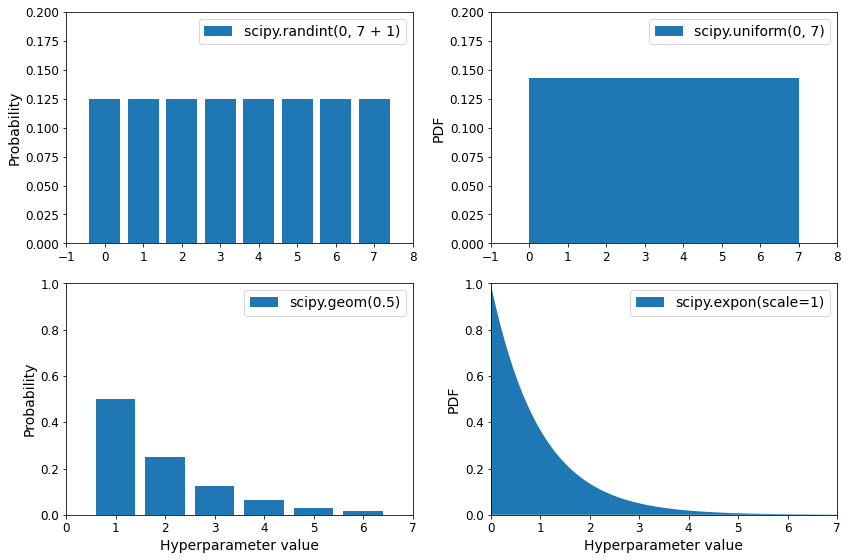

In [189]:
from scipy.stats import randint, uniform, geom, expon

xs1 = np.arange(0, 7 + 1)
randint_distrib = randint(0, 7 + 1).pmf(xs1)

xs2 = np.linspace(0, 7, 500)
uniform_distrib = uniform(0, 7).pdf(xs2)

xs3 = np.arange(0, 7, 1)
geom_distrib = geom(0.5).pmf(xs3)

xs4 = np.linspace(0, 7, 500)
expon_distrib = expon(scale=1).pdf(xs4)

plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.bar(xs1, randint_distrib, label="scipy.randint(0, 7 + 1)")
plt.ylabel("Probability")
plt.legend()
plt.axis([-1, 8, 0, 0.2])

plt.subplot(2, 2, 2)
plt.fill_between(xs2, uniform_distrib, label="scipy.uniform(0, 7)")
plt.ylabel("PDF")
plt.legend()
plt.axis([-1, 8, 0, 0.2])

plt.subplot(2, 2, 3)
plt.bar(xs3, geom_distrib, label="scipy.geom(0.5)")
plt.xlabel("Hyperparameter value")
plt.ylabel("Probability")
plt.legend()
plt.axis([0, 7, 0, 1])

plt.subplot(2, 2, 4)
plt.fill_between(xs4, expon_distrib, label="scipy.expon(scale=1)")
plt.xlabel("Hyperparameter value")
plt.ylabel("PDF")
plt.legend()
plt.axis([0, 7, 0, 1])

save_fig("distributions")
plt.show()


Here are the PDF for `expon()` and `reciprocal()` (left column), as well as the PDF of log(X) (right column). The right column shows the distribution of hyperparameter _scales_. You can see that `expon()` favors hyperparameters with roughly the desired scale, with a longer tail towards the smaller scales. But `reciprocal()` does not favor any scale, they are all equally likely:

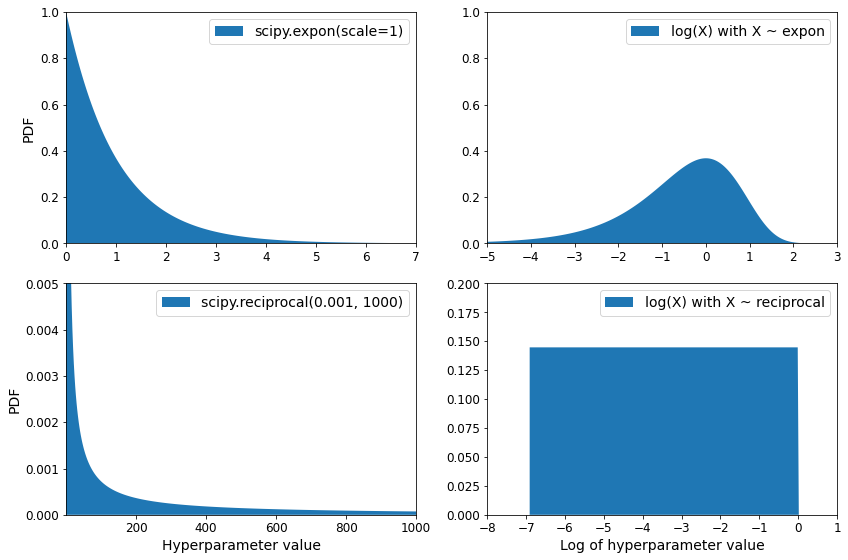

In [190]:
from scipy.stats import reciprocal

xs1 = np.linspace(0, 7, 500)
expon_distrib = expon(scale=1).pdf(xs1)

log_xs2 = np.linspace(-5, 3, 500)
log_expon_distrib = np.exp(log_xs2 - np.exp(log_xs2))  # type: ignore

xs3 = np.linspace(0.001, 1000, 500)
reciprocal_distrib = reciprocal(0.001, 1000).pdf(xs3)

log_xs4 = np.linspace(np.log(0.001), np.log(1000), 500)
log_reciprocal_distrib = uniform(np.log(0.001), np.log(1000)).pdf(log_xs4)

plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.fill_between(xs1, expon_distrib,
                 label="scipy.expon(scale=1)")
plt.ylabel("PDF")
plt.legend()
plt.axis([0, 7, 0, 1])

plt.subplot(2, 2, 2)
plt.fill_between(log_xs2, log_expon_distrib,
                 label="log(X) with X ~ expon")
plt.legend()
plt.axis([-5, 3, 0, 1])

plt.subplot(2, 2, 3)
plt.fill_between(xs3, reciprocal_distrib,
                 label="scipy.reciprocal(0.001, 1000)")
plt.xlabel("Hyperparameter value")
plt.ylabel("PDF")
plt.legend()
plt.axis([0.001, 1000, 0, 0.005])

plt.subplot(2, 2, 4)
plt.fill_between(log_xs4, log_reciprocal_distrib,
                 label="log(X) with X ~ reciprocal")
plt.xlabel("Log of hyperparameter value")
plt.legend()
plt.axis([-8, 1, 0, 0.2])

save_fig("distributions2")
plt.show()

### **5. ANALYZE BEST MODELS AND THEIR ERRORS**

In [191]:
final_model = rnd_search.best_estimator_
feature_importances = final_model["random_forest"].feature_importances_  # type: ignore
feature_importances.round(2)

array([0.07, 0.05, 0.05, 0.01, 0.01, 0.01, 0.01, 0.19, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.02, 0.  , 0.01, 0.03, 0.  , 0.01, 0.01, 0.02, 0.01,
       0.  , 0.02, 0.01, 0.  , 0.01, 0.01, 0.01, 0.  , 0.01, 0.01, 0.01,
       0.01, 0.01, 0.02, 0.01, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.03,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.  , 0.07,
       0.  , 0.  , 0.  , 0.01])

In [192]:
sorted(zip(feature_importances, final_model["preprocessing"].get_feature_names_out()),
       reverse=True)

[(0.18604899979384618, 'log_attrs__median_income'),
 (0.07371658162723976, 'cat_attrs__ocean_proximity_INLAND'),
 (0.07185354862490552, 'bedrooms_per_rooms__ratio'),
 (0.05441483794465028, 'rooms_per_house__ratio'),
 (0.05217525403622244, 'people_per_house__ratio'),
 (0.02944992663232542, 'geo_attrs__Cluster 35 similarity'),
 (0.02886736598225888, 'geo_attrs__Cluster 8 similarity'),
 (0.022986589932882003, 'geo_attrs__Cluster 15 similarity'),
 (0.022180768787349873, 'geo_attrs__Cluster 29 similarity'),
 (0.020151806298374875, 'geo_attrs__Cluster 12 similarity'),
 (0.01993922990949909, 'geo_attrs__Cluster 27 similarity'),
 (0.019333852296678503, 'geo_attrs__Cluster 5 similarity'),
 (0.013833669601583661, 'geo_attrs__Cluster 23 similarity'),
 (0.013032490764938115, 'geo_attrs__Cluster 41 similarity'),
 (0.012970777978591617, 'geo_attrs__Cluster 44 similarity'),
 (0.012671036017799394, 'geo_attrs__Cluster 36 similarity'),
 (0.012014093980772517, 'geo_attrs__Cluster 38 similarity'),
 (0.01

In [193]:
X_test = strat_test_set.drop("median_house_value", axis=1)  # type: ignore
y_test = strat_test_set["median_house_value"].copy()  # type: ignore

final_predictions = final_model.predict(X_test) # type: ignore
final_rmse = mean_squared_error(y_test, final_predictions, squared=False)
final_rmse

39662.73783423871

In [194]:
# 95% confidence interval for the RMSE.

from scipy.stats import t, sem

confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
np.sqrt(t.interval(confidence, len(squared_errors) - 1, loc=squared_errors.mean(),
                   scale=sem(squared_errors)))

array([37773.10923497, 41466.34495272])

### **6. MODEL PERSISTENCE USING JOBLIB**

In [195]:
# Save the final model.

from pathlib import Path
import joblib

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

joblib.dump(final_model, MODEL_PATH / "my_california_housing_model.pkl")

['models\\my_california_housing_model.pkl']

In [196]:
# Load the model and make some predictions.

import joblib

# extra code – excluded for conciseness
from sklearn.cluster import KMeans
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics.pairwise import rbf_kernel

def column_ratio(X):
    return X[:, [0]] / X[:, [1]]

#class ClusterSimilarity(BaseEstimator, TransformerMixin):
#    [...]

final_model_reloaded = joblib.load(MODEL_PATH / "my_california_housing_model.pkl")

new_data = housing.iloc[:5]
predictions = final_model_reloaded.predict(new_data)
predictions

array([ 75568.  , 293457.03,  81787.  , 121757.  , 228273.  ])